In [39]:
import pandas as pd
import numpy as np
import copy
import imf
import matplotlib.pyplot as plt

In [96]:
from astropy.coordinates import ICRS, Galactic
from astropy import units as u


def skycoord_from_galactic(data):
    X, Y, Z, U, V, W = data.T
    c = Galactic(
        u=X * u.pc, v=Y * u.pc, w=Z * u.pc,
        U=U * u.km / u.s, V=V * u.km / u.s, W=W * u.km / u.s,
        representation_type="cartesian",
        # Velocity representation
        differential_type="cartesian",
    )
    c_icrs = c.transform_to(ICRS())
    c_icrs.representation_type = 'spherical'
    return c_icrs

def cart2spher(data):
    X, Y, Z, U, V, W = data.T
    c = Galactic(
        u=X * u.pc, v=Y * u.pc, w=Z * u.pc,
        U=U * u.km / u.s, V=V * u.km / u.s, W=W * u.km / u.s,
        representation_type="cartesian",
        # Velocity representation
        differential_type="cartesian",
    )
    c = c.transform_to(ICRS())
    c.representation_type = 'spherical'
    ra, dec, dist = c.ra.value, c.dec.value, c.distance.value
    cos_dec = np.cos(np.radians(dec))
    pmra, pmdec, rv = c.pm_ra.value * cos_dec, c.pm_dec.value, c.radial_velocity.value
    parallax = 1000 / dist
    return np.vstack([ra, dec, parallax, pmra, pmdec, rv]).T

def spher2cart(data):
    ra, dec, parallax, pmra, pmdec, rv = data.T
    dist = 1000 / parallax
    dist[dist < 0] = 1e4
    c = ICRS(
        ra=ra * u.deg, dec=dec * u.deg, distance=dist * u.pc,
        pm_ra_cosdec=pmra * u.mas / u.yr,
        pm_dec=pmdec * u.mas / u.yr,
        radial_velocity=rv * u.km / u.s,
    )
    c = c.transform_to(Galactic())
    c.representation_type = 'cartesian'
    return np.vstack([c.u.value, c.v.value, c.w.value, c.U.value, c.V.value, c.W.value]).T

In [471]:
import re
import os
import glob
from scipy.interpolate import LinearNDInterpolator


# ----- Corrective factors for extinction correction -----
corr_Gmag = 0.83627
corr_BPmag = 1.08337
corr_RPmag = 0.63439
corr_bprp = corr_BPmag - corr_RPmag
corr_grp = corr_Gmag - corr_RPmag
# --------------------------------------------------------
# ------ Path files ------
parsec_files = '/Users/ratzenboe/Documents/work/code/Chronos/data/parsec_files/'
baraffe_files = '/Users/ratzenboe/Documents/work/code/Chronos/data/baraffe_files/'
# -----------------------


class ICBase:
    def __init__(self):
        self.data = None
        self.colnames = None
        self.l_interp = None

    def apply_extinction_by_color(self, abs_mag_g, mag_bp, mag_rp, a_v):
        """Apply extinction to individual isochrone"""
        if isinstance(a_v, np.ndarray):
            av_add = a_v[None, :]
        elif isinstance(a_v, (list, tuple)):
            av_add = np.array(a_v)[None, :]
        else:
            av_add = a_v
        # Compute extincted magnitudes and colors
        extincted_mag_g = abs_mag_g + av_add * corr_Gmag
        extincted_mag_bp = mag_bp + av_add * corr_BPmag
        extincted_mag_rp = mag_rp + av_add * corr_RPmag
        return extincted_mag_g, extincted_mag_bp, extincted_mag_rp
    
    def fit_interpolator(self, n_skip=10):
        df_subset = self.data[::n_skip]
        cols_input = [self.colnames['mass'], self.colnames['age'], self.colnames['metal']]
        cols_predict = [
            self.colnames['gmag'], self.colnames['bp'], self.colnames['rp'], 
            self.colnames['logg'], self.colnames['teff']
        ] 
        X = df_subset[cols_input].values
        y = df_subset[cols_predict].values
        self.l_interp = LinearNDInterpolator(X, y)
    
    def query_cmd(self, mass, age, metal, av=0):
        if not isinstance(mass, np.ndarray):
            mass = np.array([mass])
            age = np.array([age])
            metal = np.array([metal])
        # Query the interpolator
        X_query = np.vstack([mass, age, metal]).T
        # Interpolate
        abs_mag_g, abs_mag_bp, abs_mag_rp, logg, teff = self.l_interp(X_query).T
        # Apply extinction
        # abs_mag_g_ext, mag_bp_ext, mag_rp_ext = self.apply_extinction_by_color(
        #     abs_mag_g, mag_bp, mag_rp, av
        # )
        df = pd.DataFrame(
            np.vstack([abs_mag_g, abs_mag_bp, abs_mag_rp, logg, teff]).T,
            columns=['M_G', 'G_BP', 'G_RP', 'logg', 'teff']
        )
        return df


class PARSEC(ICBase):
    """Handling Gaia (E)DR3 photometric system"""
    def __init__(self, dir_path, file_ending='dat'): #, nb_interpolated=400):
        super().__init__()
        # Save some PARSEC internal column names
        self.comment = r'#'
        self.colnames = {
            'mass': 'Mass',
            'logg': 'logg',
            'teff': 'logTe',
            'age': 'logAge',
            'metal': 'MH',
            'gmag': 'Gmag',
            'bp': 'G_BPmag',
            'rp': 'G_RPmag',
            'header_start': '# Zini'
        }
        self.post_process = {self.colnames['teff']: lambda x: 10 ** x}
        # Save data and rename columns
        self.dir_path = dir_path
        self.flist_all = glob.glob(os.path.join(dir_path, f'*.{file_ending}'))
        self.data = self.read_files(self.flist_all)
        # Prepare interpolation method
        self.fit_interpolator(n_skip=5)

    def read_files(self, flist):
        frames = []
        for fname in flist:
            df_iso = self.read(fname)
            # Postprocessing
            for col, func in self.post_process.items():
                df_iso[col] = df_iso[col].apply(func)
            frames.append(df_iso)
        print('PARSEC isochrones read and processed!')
        return pd.concat(frames)

    def read(self, fname):
        """
        Fetches the coordinates of a single isochrone from a given file and retrurns it
        :param fname: File name containing information on a single isochrone
        :return: x-y-Coordinates of a chosen isochrone, age, metallicity
        """
        df_iso = pd.read_csv(fname, delim_whitespace=True, comment=self.comment, header=None)
        # Read first line and extract column names
        with open(fname) as f:
            for line in f:
                if line.startswith(self.colnames['header_start']):
                    break
        line = re.sub(r'\t', ' ', line)  # remove tabs
        line = re.sub(r'\n', ' ', line)  # remove newline at the end
        line = re.sub(self.comment, ' ', line)  # remove '#' at the beginning
        col_names = [elem for elem in line.split(' ') if elem != '']
        # Add column names
        df_iso.columns = col_names
        return df_iso


class Baraffe15(ICBase):
    """Handling Gaia (E)DR3 photometric system"""
    def __init__(self, dir_path, file_ending='GAIA'):
        super().__init__()
        # Save some PARSEC internal column names
        self.comment = r'!'
        self.colnames = {
            'mass': 'M/Ms',
            'logg': 'g',
            'teff': 'Teff',
            'age': 'logAge',
            'metal': 'feh',
            'gmag': 'G',
            'bp': 'G_BP',
            'rp': 'G_RP',
            'header_start': '! M/Ms',
            'age_start': '!  t (Gyr) ='
        }
        # Save data and rename columns
        self.dir_path = dir_path
        self.flist_all = glob.glob(os.path.join(dir_path, f'*.{file_ending}'))
        self.data = self.read_files(self.flist_all)
        # Prepare interpolation method
        self.fit_interpolator(n_skip=1)

    def read_files(self, flist):
        frames = []
        for fname in flist:
            df_iso = self.read(fname)
            frames.append(df_iso)
        print('Baraffe+15 isochrones read and processed!')
        if len(frames) == 1:
            return frames[0]
        return pd.concat(frames)

    def read(self, fname):
        """
        Fetches the coordinates of a single isochrone from a given file and retrurns it
        :param fname: File name containing information on a single isochrone
        :return: x-y-Coordinates of a chosen isochrone, age, metallicity
        """
        df_iso = pd.read_csv(fname, delim_whitespace=True, header=None, comment=self.comment)
        # Read first line and extract column names
        with open(fname) as f:
            for line in f:
                if line.startswith(self.colnames['header_start']):
                    break
        line = re.sub(r'\t', ' ', line)  # remove tabs
        line = re.sub(r'\n', ' ', line)  # remove newline at the end
        line = re.sub(self.comment, ' ', line)  # remove '!' at the beginning
        col_names = [elem for elem in line.split(' ') if elem != '']
        # Add column names
        df_iso.columns = col_names
        # Post process: add ages
        counter = 0
        nb_entries_per_isochrone = []
        logAge_info = []
        with open(fname) as f:
            line_info = []
            for i, line in enumerate(f):
                if line.startswith('!---'):
                    counter += 1
                    if counter == 2:
                        line_info.append(i + 1)
                    if counter == 3:
                        line_info.append(i - 1)

                if line.startswith(self.colnames['age_start']):
                    line = re.sub(r'\t', ' ', line)  # remove tabs
                    age = float(re.findall("\d+\.\d+", line)[0])
                    logAge = np.round(np.log10(age * 10**9), decimals=2)
                    logAge_info.append(logAge)
                    # Save infos
                    if len(line_info) > 0:
                        counter = 0
                        nb_entries_per_isochrone.append(line_info[1] - line_info[0])
                        line_info = []
        nb_entries_per_isochrone.append(line_info[1] - line_info[0])
        # --- Add age ---
        df_iso[self.colnames['age']] = -1.0
        rolling_sum = 0
        for entry, logAge in zip(nb_entries_per_isochrone, logAge_info):
            end = entry + rolling_sum + 1
            df_iso[self.colnames['age']].iloc[rolling_sum:end] = logAge
            rolling_sum = end
        # --- Add metal (at least 2 points to allow interpolation) ---
        # todo: fix interpolator to a single argument
        df_iso[self.colnames['metal']] = -1.
        df_iso_1 = copy.deepcopy(df_iso)
        df_iso_1[self.colnames['metal']] = 1.
        data = pd.concat([df_iso, df_iso_1])
        return data
    
    
class ClusterPhotometry:
    def __init__(self, parsec_folder, baraffe_folder, M_G_threshold=5):
        self.p_obj = PARSEC(parsec_folder)
        self.b_obj = Baraffe15(baraffe_folder)
        self.M_G_threshold = M_G_threshold
        self.source_data_photometry = None
        self.data_photometry_binaries = None
        self.data_phot = None
        
    def make_photometry(self, cluster_mass, logAge, feh=0, f_bin_total=0.5):
        mass_samples = imf.make_cluster(cluster_mass)
        mass_samples = np.sort(mass_samples)
        logAge_samples = np.full_like(mass_samples, logAge)
        feh_samples = np.full_like(mass_samples, feh)
        
        df_parsec = self.p_obj.query_cmd(mass_samples, logAge_samples, feh_samples)
        df_baraffe = self.b_obj.query_cmd(mass_samples, logAge_samples, feh_samples)
        df_parsec['mass'] = mass_samples
        df_baraffe['mass'] = mass_samples
        
        idx_parsec = np.where(df_parsec.M_G < self.M_G_threshold)[0].min()
        # Use Baraffe for lower main sequence, PARSEC for upper MS
        self.source_data_photometry = pd.concat([df_baraffe[:idx_parsec], df_parsec[idx_parsec:]])
        if f_bin_total > 0:
            self.add_binaries(f_bin_total)
            self.data_phot = self.data_photometry_binaries
            return self.data_photometry_binaries
        else:
            self.data_phot = self.source_data_photometry
            return self.source_data_photometry
    
    @staticmethod
    def add_magnitudes(*args):
        return -2.5 * np.log10(np.sum([10**(-0.4 * M_i) for M_i in args], axis=0)) 
    
    def create_binaries_pairs(self, f_bin_total):
        n = self.source_data_photometry.shape[0]
        random_idx_pairs = np.array([[i, j] for i, j in zip(np.arange(n),  np.random.permutation(n))])
        rand_pairs_boolarr = np.random.uniform(0, 1, n) < f_bin_total
        random_idx_pairs_filtered = random_idx_pairs[rand_pairs_boolarr]
        # Sort by joint mass
        random_idx_pairs_filtered = random_idx_pairs_filtered[random_idx_pairs_filtered.sum(axis=1).argsort()][::-1]
        all_pairs_final = []
        unique_sources = set()
        for i, j in random_idx_pairs_filtered:
            if (i not in unique_sources) and (j not in unique_sources):
                all_pairs_final.append([i, j])
                unique_sources.add(i)
                unique_sources.add(j)
        return np.array(all_pairs_final)
        
    def add_binaries(self, f_bin_total):
        all_pairs_final = self.create_binaries_pairs(f_bin_total)
        max_nb = np.max(all_pairs_final, axis=1)
        min_nb = np.min(all_pairs_final, axis=1)
        # Create copy to store binaries in
        self.data_photometry_binaries = self.source_data_photometry.copy()
        # Get photometry of given ids
        df_max = self.data_photometry_binaries.loc[max_nb]
        df_min = self.data_photometry_binaries.loc[min_nb]
        # Compute the combined photometry
        for col in ['M_G', 'G_BP', 'G_RP']:
            self.data_photometry_binaries.loc[max_nb, col] = self.add_magnitudes(
                df_max[col].values, df_min[col].values
            )
        # Compute the combined logg and teff
        for col in ['logg', 'teff']:
            self.data_photometry_binaries.loc[max_nb, col] = np.max(
                np.vstack([df_max[col].values, df_min[col].values]), axis=0
            )
        # Compute combined mass
        self.data_photometry_binaries.loc[max_nb, 'mass'] = df_max['mass'].values #+ df_min['mass'].values
        # Save is binary as columns
        self.data_photometry_binaries['is_binary'] = 0
        self.data_photometry_binaries.loc[max_nb, 'is_binary'] = 1
        self.data_photometry_binaries.loc[min_nb, 'is_binary'] = -1
        # Remove min_nb from the source data
        self.data_photometry_binaries = self.data_photometry_binaries.drop(min_nb)
        return

# Build cluster sampler

In [472]:
from astropy.coordinates import ICRS, Galactic, SkyCoord
from astropy import units as u


class ClusterSampler(ClusterPhotometry): 
    def __init__(self, mu, cov, mass, logAge, feh, f_bin, parsec_folder, baraffe_folder, M_G_threshold=5):
        super().__init__(parsec_folder, baraffe_folder, M_G_threshold)
        # super().__init__(astrometric_fname, rv_fname)
        self.cluster_mu = mu
        self.cluster_cov = cov
        self.cluster_mass = mass
        self.cluster_logAge = logAge
        self.cluster_feh = feh
        self.f_bin_total = f_bin
        # Source data
        self.cluster_size = None
        # Simpulated cluster data
        self.skycoord = None
        self.X_gal = None
        self.X_icrs = None
        # Observed data
        # self.X_obs_gal = None
        # self.X_obs_icrs = None
        
    def set_cluster_params(self, mu, cov, mass, logAge, feh, f_bin):
        self.cluster_mu = mu
        self.cluster_cov = cov
        self.cluster_mass = mass
        self.cluster_logAge = logAge
        self.cluster_feh = feh
        self.f_bin_total = f_bin
        
    @staticmethod
    def skycoord_from_galactic(data):
        X, Y, Z, U, V, W = data.T
        c = Galactic(
            u=X * u.pc, v=Y * u.pc, w=Z * u.pc,
            U=U * u.km / u.s, V=V * u.km / u.s, W=W * u.km / u.s,
            representation_type="cartesian",
            # Velocity representation
            differential_type="cartesian",
        )
        c_icrs = c.transform_to(ICRS())
        c_icrs.representation_type = 'spherical'
        skycoords = SkyCoord(c_icrs)
        return skycoords
        
    def simulate_cluster(self):
        __data = self.make_photometry(self.cluster_mass, self.cluster_logAge, self.cluster_feh, self.f_bin_total)
        self.cluster_size = __data.shape[0]
        # Create cluster data in XYZ+UVW
        self.X_gal = pd.DataFrame(
            np.random.multivariate_normal(self.cluster_mu, self.cluster_cov, self.cluster_size),
            columns=['X', 'Y', 'Z', 'U', 'V', 'W']
        )
        # Convert to ICRS
        self.skycoord = self.skycoord_from_galactic(self.X_gal.values)
    
        # Simulate errors
        # self.simulate_errors(self.cluster_size)
        # # Convolve the data with measurement uncertainties
        # self.X_obs_icrs = self.convolve(self.X_icrs)
        # self.X_obs_gal = spher2cart(self.X_obs_icrs)
        return

In [473]:
cluster_kwargs = dict(
    mu=[10, 10, -10, 20, 20, -10],
    cov=np.eye(6),
    mass=1e3,
    logAge=7.2,
    feh=0,
    f_bin=0.1,
)

cs = cluster_sampler = ClusterSampler(
    **cluster_kwargs,
    parsec_folder=parsec_files,
    baraffe_folder=baraffe_files,
    M_G_threshold=5
)

PARSEC isochrones read and processed!
Baraffe+15 isochrones read and processed!


In [474]:
%%time

cluster_kwargs = dict(
    mu=[300, 200, -100, 20, 20, -10],
    cov=np.eye(6),
    mass=1e3,
    logAge=7.2,
    feh=0,
    f_bin=0.3,
)

cs.set_cluster_params(**cluster_kwargs)
cs.simulate_cluster()

Total cluster mass is 999.947 (limit was 1000)
CPU times: user 1.31 s, sys: 4.48 ms, total: 1.31 s
Wall time: 446 ms


In [475]:
cs.f_bin_total

0.3

(0.0, 1.0)

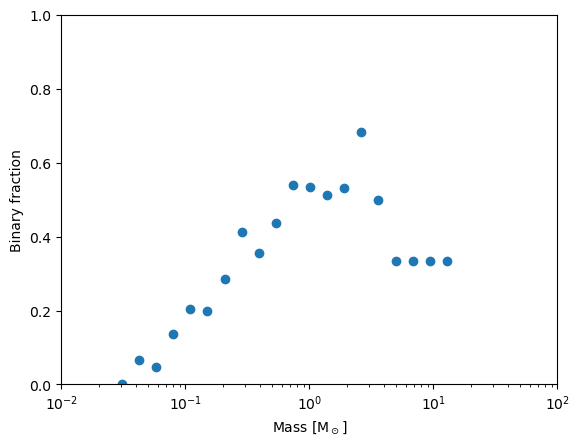

In [476]:
# Check binary fraction per mass bin
nb_bins, bins = np.histogram(cs.data_photometry_binaries.mass, bins=np.logspace(-2, 2, 30))

binary_fraction = []
mass_max_companion = []

for bin_lo, bin_hi in zip(bins[:-1], bins[1:]):
    mask = (cs.data_photometry_binaries.mass >= bin_lo) & (cs.data_photometry_binaries.mass < bin_hi)
    n_tot = np.sum(mask)
    n_binary = np.sum(cs.data_photometry_binaries.is_binary[mask] == 1)
    bin_center = np.mean([bin_lo, bin_hi])
    if n_tot > 2:
        binary_fraction.append(n_binary / n_tot)
        mass_max_companion.append(bin_center)
        
plt.scatter(mass_max_companion, binary_fraction)
plt.gca().set_xscale('log')
plt.gca().set_xlim(0.01, 100)
plt.xlabel('Mass [M$_\odot$]')
plt.ylabel('Binary fraction')
plt.ylim(0, 1)

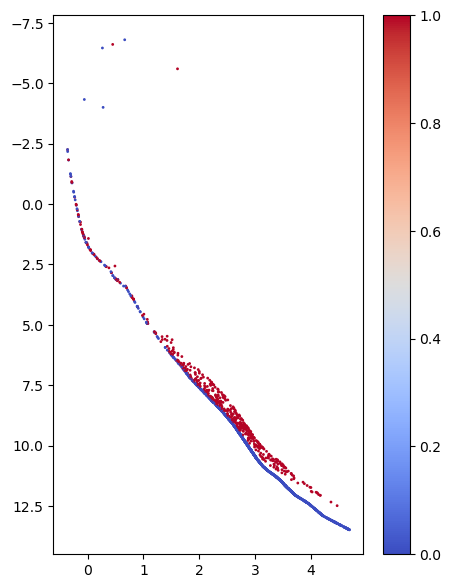

In [477]:
dat = cs.data_photometry_binaries.copy()
dat_orig = cs.source_data_photometry.copy()

plt.figure(figsize=(5, 7))
plt.scatter(dat.G_BP - dat.G_RP, dat.M_G, s=1, c=dat.is_binary, cmap='coolwarm')
# plt.scatter(dat_orig.G_BP - dat_orig.G_RP, dat_orig.M_G, s=10)
plt.gca().invert_yaxis()
plt.colorbar()

# Uncertainty classification

## Determine the number of observations

In [478]:
from pygaia.errors.spectroscopic import radial_velocity_uncertainty
from pygaia.errors.astrometric import parallax_uncertainty
import scipy.interpolate as interpolate
from gaiaunlimited.selectionfunctions import DR3SelectionFunctionTCG
from gaiaunlimited.scanninglaw import GaiaScanningLaw


class Edr3LogMagUncertainty:
    """
    Estimate the log(mag) vs mag uncertainty for G, G_BP, G_RP based on Gaia EDR3 photometry.
    """
    def __init__(self, spline_csv, n_obs=200):
        """Usage
        >>> u = Edr3LogMagUncertainty('LogErrVsMagSpline.csv')
        >>> gmags = np.array([5, 10, 15, 20])
        >>> g200 = u.log_mag_err('g', gmags, 200)
        """
        _df = pd.read_csv(spline_csv)
        splines = dict()
        splines['g'] = self.__init_spline(_df, 'knots_G', 'coeff_G')
        splines['bp'] = self.__init_spline(_df, 'knots_BP', 'coeff_BP')
        splines['rp'] = self.__init_spline(_df, 'knots_RP', 'coeff_RP')
        self.__splines = splines
        self.__nobs_baseline = {'g': 200, 'bp': 20, 'rp': 20}
        self.n_obs = self.set_nobs(n_obs)
        
    def set_nobs(self, n_obs):
        """Set the number of observations for G, G_BP, G_RP bands.
        The numbers are proportional to the number of matched_transits in Gaia (can be computed via GaiaScanningLaw).
        """
        self.n_obs = None
        if isinstance(n_obs, int):
            if n_obs > 0:
                self.n_obs = {
                    'g': n_obs * 8.5, 'bp': n_obs * 0.95, 'rp': n_obs * 0.91
                }
        elif isinstance(n_obs, np.ndarray):
            self.n_obs = {}
            self.n_obs['g'] = n_obs * 8.5
            self.n_obs['bp'] = n_obs * 0.95
            self.n_obs['rp'] = n_obs * 0.91
        return
        
    def __init_spline(self, df, col_knots, col_coeff):
        __ddff = df[[col_knots, col_coeff]].dropna()
        return interpolate.BSpline(__ddff[col_knots], __ddff[col_coeff], 3, extrapolate=False)

    def log_mag_err(self, band, mag_val, n_obs=None):
        if n_obs is not None:
            self.set_nobs(n_obs)
        # If number of observations was not passed
        if self.n_obs is None:
            return 10**self.__splines[band](mag_val)
        
        return 10**(self.__splines[band](mag_val) - np.log10(np.sqrt(self.n_obs[band]) / np.sqrt(self.__nobs_baseline[band])))


class PhotHandler:
    def __init__(self, cluster_object, spline_csv):
        self.cluster_object = cluster_object
        print('Initializing the scanning law object...')
        self.sl = GaiaScanningLaw('dr3_nominal')
        self.n_obs = self.query_nobs()
        # Compute apparent magnitude uncertainties
        self.spline_csv = spline_csv
        self.u = None
        self.g_mag_err = None
        self.bp_mag_err = None
        self.rp_mag_err = None
        self.compute_uncertainties_phot()
        
    def compute_uncertainties_phot(self):
        self.u = Edr3LogMagUncertainty(self.spline_csv, self.n_obs)
        self.g_mag_err = self.u.log_mag_err('g', self.g_mag())
        self.bp_mag_err = self.u.log_mag_err('bp', self.bp_mag())
        self.rp_mag_err = self.u.log_mag_err('rp', self.rp_mag())
        
    def M_G(self):
        return self.cluster_object.data_phot['M_G'].values
    
    def M_Gbp(self):
        return self.cluster_object.data_phot['G_BP'].values
    
    def M_Grp(self):
        return self.cluster_object.data_phot['G_RP'].values
    
    def teff(self):
        return self.cluster_object.data_phot['teff'].values
    
    def logg(self):
        return self.cluster_object.data_phot['logg'].values
    
    def apparent_mag(self, M):
        distance = self.cluster_object.skycoord.distance.value
        return M + 5 * np.log10(distance) - 5

    def g_mag(self):
        return self.apparent_mag(self.M_G())
    
    def bp_mag(self):
        return self.apparent_mag(self.M_Gbp())
    
    def rp_mag(self):
        return self.apparent_mag(self.M_Grp())
    
    def query_nobs(self):
        ra = self.cluster_object.skycoord.ra.value
        dec = self.cluster_object.skycoord.dec.value
        # Define helper function
        def get_totaln(*args):
            return sum(self.sl.query(*args, count_only=True))
        # Query the number of observations
        n_obs = [get_totaln(*args) for args in zip(ra, dec)]
        return np.array(n_obs)
    

class GaiaUncertainties(PhotHandler):
    def __init__(self, cluster_object: ClusterSampler, spline_csv: str, release: str='dr3'):
        """Takes effective temperature, surface gravity, absolute G, BP, RP magnitudes, and the distance.
        Computes parallax, radial velocity, and proper motion uncertainties.
        See: https://www.cosmos.esa.int/web/gaia/science-performance#spectroscopic%20performance
        """
        super().__init__(cluster_object, spline_csv)
        self.release = release
        # G_RVS maginitude
        self.g_rvs = self.compute_grvs(self.g_mag(), self.rp_mag())
        # Uncertainties to compute
        self.ra_err = None
        self.dec_err = None
        self.plx_err = None
        self.pmra_err = None
        self.pmdec_err = None
        self.rv_err = None
        self.completeness = None
        # Compute uncertainties
        self.compute_uncertainties_astrometry()
        # Estimate completeness
        print('Estimating completeness...')
        self.estimate_completeness()
        
    def new_cluster(self, cluster_object):
        self.cluster_object = cluster_object
        self.n_obs = self.query_nobs()
        self.compute_uncertainties_phot()
        self.compute_uncertainties_astrometry()
        self.estimate_completeness()
        return
        
    def estimate_completeness(self):
        """Estimate the completeness of the cluster"""
        # Compute the completeness
        mapHpx7 = DR3SelectionFunctionTCG()
        self.completeness = mapHpx7.query(self.cluster_object.skycoord, self.g_mag())
        return 

    def compute_parallax_uncertainty(self):
        """Compute parallax uncertainty in mas
        Function parallax_uncertainty returns paralax uncertainty in µas
        """
        if self.n_obs is None:
            self.plx_err = parallax_uncertainty(self.g_mag(), release=self.release) / 1_000.
        else:
            __nobs_baseline_plx = 200
            __nobs_astrometric_good = 8.3 * self.n_obs
            n_obs_relative = __nobs_astrometric_good / __nobs_baseline_plx
            self.plx_err = parallax_uncertainty(self.g_mag(), release=self.release) / 1_000. / np.sqrt(n_obs_relative)
        return
    
    def compute_uncertainties_astrometry(self):
        """Compute uncertainties for the astrometric parameters
        For the conversion factors see: 
            https://www.cosmos.esa.int/web/gaia/science-performance#spectroscopic%20performance
        """
        self.compute_parallax_uncertainty()
        self.ra_err = 0.8 * self.plx_err
        self.dec_err = 0.7 * self.plx_err
        self.pmra_err = 1.03 * self.plx_err
        self.pmdec_err = 0.89 * self.plx_err
        self.rv_err = radial_velocity_uncertainty(self.g_mag(), self.teff(), self.logg(), release=self.release)
        return

    @staticmethod
    def compute_grvs(G, Grp):
        g_rp = G - Grp
        f1_g_rvs = -0.0397 - 0.2852*g_rp - 0.033*g_rp**2 - 0.0867*g_rp**3
        f2_g_rvs = -4.0618 + 10.0187*g_rp - 9.0532*g_rp**2 + 2.6089*g_rp**3
        # functions valid within the following ranges
        range_1 = g_rp < 1.2
        range_2 = 1.2 <= g_rp
        # Compute G_RVS
        if isinstance(G, np.ndarray):
            grvs = np.zeros_like(g_rp)
            grvs[range_1] = f1_g_rvs[range_1] + Grp[range_1]
            grvs[range_2] = f2_g_rvs[range_2] + Grp[range_2]
            return grvs
        else:
            if range_1:
                return f1_g_rvs + Grp
            else:
                return f2_g_rvs + Grp

In [479]:
%%time
g_unc = GaiaUncertainties(cluster_object=cs, spline_csv='LogErrVsMagSpline.csv')

Initializing the scanning law object...
Estimating completeness...
CPU times: user 2.43 s, sys: 298 ms, total: 2.73 s
Wall time: 3.15 s


In [551]:
%%time

cluster_kwargs = dict(
    mu=[10, 10, 10, 20, 20, -10],
    cov=np.eye(6),
    mass=1e3,
    logAge=7.2,
    feh=0,
    f_bin=0.3,
)

cs.set_cluster_params(**cluster_kwargs)
cs.simulate_cluster()

g_unc.new_cluster(cs)

Total cluster mass is 999.518 (limit was 1000)
CPU times: user 1.31 s, sys: 3.3 ms, total: 1.31 s
Wall time: 1.44 s


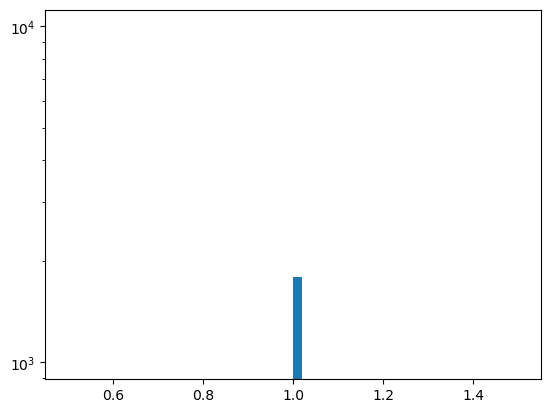

In [537]:
plt.hist(g_unc.completeness, bins=50, log=True);

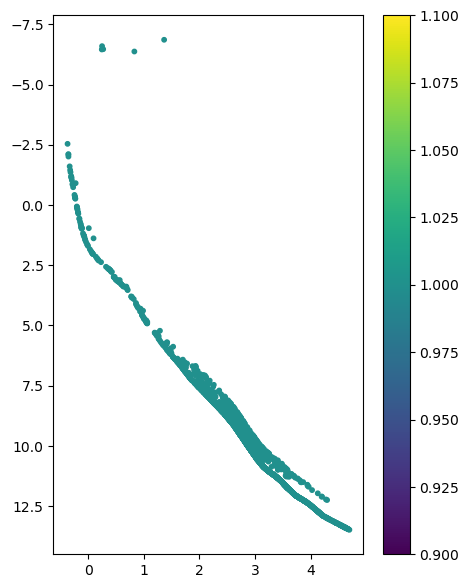

In [538]:
dat = cs.data_photometry_binaries

plt.figure(figsize=(5, 7))
plt.scatter(dat.G_BP - dat.G_RP, dat.M_G, c=g_unc.completeness, s=10)
plt.gca().invert_yaxis()
plt.colorbar()

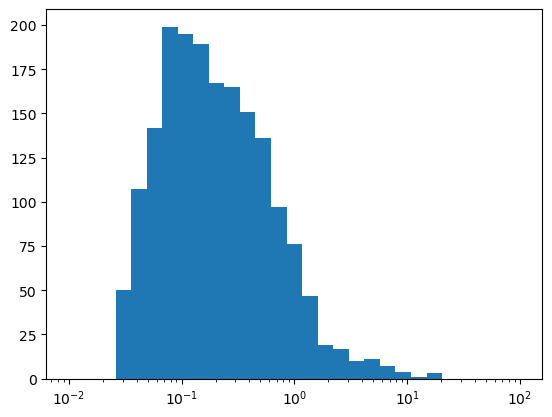

In [539]:
plt.hist(cs.data_phot.mass, bins=np.logspace(-2, 2, 30)); #, g_unc.g_mag().shape
# log x axis
plt.gca().set_xscale('log')

# Convolve with realistic uncertainties

In [540]:
class ErrorBase:
    def __init__(self, unc_obj: GaiaUncertainties, astrometric_fname: str):
        self.unc_obj = unc_obj
        self.astrometric_mean = None
        self.astrometric_cov = None
        # Load the astrometric parameters
        self.set_astrometric_params(astrometric_fname)
        # Define the columns for the astrometric and radial velocity parameters
        self.astrometric_errors = [
            "ra_error", "dec_error", "parallax_error", "pmra_error", "pmdec_error", "radial_velocity_error"
        ]
        self.cols_mags = ['M_G', 'G_BP', 'G_RP']
        # Define the astrometric features and errors
        self.features = [
            "ra", "dec", "parallax", "pmra", "pmdec", "radial_velocity", "M_G", "G_BP", "G_RP"
        ]
        # Correlation positions in correlation/covariance matrix
        self.corr_map = {
            "ra_dec_corr": [0, 1],
            "ra_parallax_corr": [0, 2],
            "ra_pmra_corr": [0, 3],
            "ra_pmdec_corr": [0, 4],
            "dec_parallax_corr": [1, 2],
            "dec_pmra_corr": [1, 3],
            "dec_pmdec_corr": [1, 4],
            "parallax_pmra_corr": [2, 3],
            "parallax_pmdec_corr": [2, 4],
            "pmra_pmdec_corr": [3, 4],
        }
        self.X = self.set_X()
        # Prepare cov. matrix and Cholesky decomposition storage
        self.X_err = None  # error features
        self.C = None  # covariance matrix for "astrometric_features" features
        self.L = None  # Cholesky decomposition, needed for fast sampling with numba
        
    def set_X(self):
        c = self.unc_obj.cluster_object.skycoord
        ra, dec, dist = c.ra.value, c.dec.value, c.distance.value
        cos_dec = np.cos(np.radians(dec))
        pmra, pmdec, rv = c.pm_ra.value * cos_dec, c.pm_dec.value, c.radial_velocity.value
        parallax = 1000 / dist
        # Set the astrometric features + magnitudes
        X = np.vstack([
            ra, dec, parallax, pmra, pmdec, rv,
            self.unc_obj.g_mag(),
            self.unc_obj.bp_mag(),
            self.unc_obj.rp_mag()
        ]).T
        return X
 
    def set_astrometric_params(self, fname):
        npzfile = np.load(fname)
        self.astrometric_mean = npzfile['mean']
        self.astrometric_cov = npzfile['cov']

    def simulate_astrometric_cov(self, n_samples):
        return np.random.multivariate_normal(self.astrometric_mean, self.astrometric_cov, n_samples)
    
    def run_checks(self):
        eps = 1.e-4
        # Correlations need to be in [-1, 1]
        for col in self.corr_map.keys():
            self.X_err.loc[self.X_err[col] > 1, col] = 1 - eps
            self.X_err.loc[self.X_err[col] < -1, col] = -1 + eps
        return
    
    def simulate_errors(self, n_samples):
        astrometric_errors = self.simulate_astrometric_cov(n_samples)
        # return astrometric_errors, rv_errors
        self.X_err = pd.DataFrame(astrometric_errors, columns=list(self.corr_map.keys()))
        self.run_checks()
        self.build_covariance_matrix()
        return

    def build_covariance_matrix(self):
        """Create covariance matrix from input features"""
        # Start building covariance matrix
        nb_sources, nb_features = self.X.shape
        self.C = np.zeros((nb_sources, nb_features, nb_features), dtype=np.float32)
        eps = 0.0001
        diag = np.arange(nb_features)
        self.C[:, 0, 0] = self.unc_obj.ra_err
        self.C[:, 1, 1] = self.unc_obj.dec_err
        self.C[:, 2, 2] = self.unc_obj.plx_err
        self.C[:, 3, 3] = self.unc_obj.pmra_err
        self.C[:, 4, 4] = self.unc_obj.pmdec_err
        self.C[:, 5, 5] = self.unc_obj.rv_err
        self.C[:, 6, 6] = self.unc_obj.g_mag_err
        self.C[:, 7, 7] = self.unc_obj.bp_mag_err
        self.C[:, 8, 8] = self.unc_obj.rp_mag_err
        # Remove nans
        self.C = np.nan_to_num(self.C, nan=1e3, copy=True)
        # Squre variance -> std dev
        self.C[:, diag, diag] = self.C[:, diag, diag] ** 2

        # ----- Fill in off-diagonal elements -----
        for column, (i, j) in self.corr_map.items():
            self.C[:, i, j] = self.X_err[column].fillna(0).to_numpy(dtype=np.float32).ravel()
            self.C[:, i, j] *= (
                    self.C[:, i, i] * self.C[:, j, j]
            )  # transform correlation to covariance
            self.C[:, j, i] = self.C[:, i, j]  # fill in symmetric component        
        # Compute Cholesky decomposition
        epsilon = 0.0001  # Define epsilon to add small pertubation to
        self.L = copy.deepcopy(self.C) #.copy()
        # add small pertubation to covariance matrix, because its eigenvalues can decay
        # very rapidly and without this stabilization the Cholesky decomposition fails
        self.L[:, diag, diag] += epsilon
        #  Cholesky decomposition:
        for k in range(nb_sources):
            # set i'th element to Cholensky decomposition of covariance matrix
            try:
                self.L[k, :, :] = np.linalg.cholesky(self.L[k, :, :])
            except np.linalg.LinAlgError:
                # Make positive definite
                min_ev = np.linalg.eigvals(self.L[k, :, :]).min()
                C_new = self.L[k, :, :] + (-min_ev + epsilon) * np.eye(nb_features)
                self.L[k, :, :] = np.linalg.cholesky(C_new)

    def convolve(self):
        nb_points, nb_covfeats = self.X.shape[0], len(self.features)
        if nb_points != self.L.shape[0]:
            raise ValueError("Number of points in X and L do not match")
        
        add2X = self.__new_sample(self.L, nb_points, nb_covfeats)
        X_new = self.X + np.asarray(add2X)
        # Check if the declination angle is out of bounds, if so we fix that
        X_new[:, 0], X_new[:, 1] = self.transform_to_radec_bounds(
            ra=X_new[:, 0], dec=X_new[:, 1]
        )
        return X_new

    @staticmethod
    def __new_sample(L, nb_points, nb_covfeats):
        """Sample a single data point from normal distribution
        Here we calculate the distance we have to travel away from data point:
        X'[i] = X[i] + sample_list[i]
        """
        sample_list = list()
        for i in range(nb_points):
            u = np.random.normal(loc=0, scale=1, size=nb_covfeats).astype(np.float32)
            mult = L[i] @ u
            sample_list.append(mult)
        return sample_list

    def transform_to_radec_bounds(self, ra, dec):
        # skycoords can deal with ra>360 or ra<0, but not with dec out of [-90, 90]
        dec_under_range = dec < -90.0
        dec_over_range = dec > 90.0
        # Mirror the declination angle
        if np.any(dec_under_range):
            dec[dec_under_range] += 2 * (np.abs(dec[dec_under_range]) - 90)
            ra[dec_under_range] += 180
        if np.any(dec_over_range):
            dec[dec_over_range] -= 2 * (np.abs(dec[dec_over_range]) - 90)
            ra[dec_over_range] += 180
        # Correct ra if it is out of bounds
        ra_over_range = ra > 360
        ra_under_range = ra < 0
        if np.any(ra_over_range):
            ra[ra_over_range] -= 360
        if np.any(ra_under_range):
            ra[ra_under_range] += 360
        return ra, dec

In [557]:
c = g_unc.cluster_object.skycoord
ra, dec, dist = c.ra.value, c.dec.value, c.distance.value
cos_dec = np.cos(np.radians(dec))
pmra, pmdec, rv = c.pm_ra.value * cos_dec, c.pm_dec.value, c.radial_velocity.value
parallax = 1000 / dist

X = np.vstack([
    ra, dec, parallax, pmra, pmdec, rv,
    g_unc.g_mag(),
    g_unc.bp_mag(),
    g_unc.rp_mag()
]).T

In [559]:
X.shape

(1711, 9)

In [566]:
nb_sources, nb_features = X.shape
C = np.zeros((nb_sources, nb_features, nb_features), dtype=np.float32)
C[:, 0, 0] = g_unc.ra_err
C[:, 1, 1] = g_unc.dec_err
C[:, 2, 2] = g_unc.plx_err
C[:, 3, 3] = g_unc.pmra_err
C[:, 4, 4] = g_unc.pmdec_err
C[:, 5, 5] = g_unc.rv_err
C[:, 6, 6] = g_unc.g_mag_err
C[:, 7, 7] = g_unc.bp_mag_err
C[:, 8, 8] = g_unc.rp_mag_err
# Remove nans
C = np.nan_to_num(C, nan=1e3, copy=True)
# Fill in off-diagonal elements
corr_map = 
for column, (i, j) in self.corr_map.items():
    self.C[:, i, j] = self.X_err[column].fillna(0).to_numpy(dtype=np.float32).ravel()
    self.C[:, i, j] *= (
            self.C[:, i, i] * self.C[:, j, j]
    )  # transform correlation to covariance
    self.C[:, j, i] = self.C[:, i, j]  # fill in symmetric component


0

In [543]:
np.sum(np.isnan(g_unc.bp_mag_err))

77

In [550]:
np.sum(~np.isnan(g_unc.rv_err))

100